## Starkniederschlag in Berlin: Fallstudie 29.6.2017

### Umgebung einrichten

In [1]:
import os
import wradlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import KDTree
import helpers as h
import datetime as dt
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap, to_hex
from matplotlib.lines import Line2D

In [2]:
%matplotlib inline

### Konfiguration

In [3]:
#dxdir = "/media/x/data/radar/dx/pro/DX-pro_201906/DX-pro_20190610/raa00-dx_10392-1906100000-pro---bin"
#dxdirpattern = "/media/x/data/radar/dx_for_berlin/pro/DX-pro_%s/DX-pro_%s/raa00-dx_10392-%s-pro---bin"
dxdirpattern = "dx/raa00-dx_10392-%s-pro---bin"
##rwdirpattern = "rw/raa01-rw_10000-%s-dwd---bin.gz"
rwdirpattern = "rw-ra17/raa01-rw2017.002_10000-%s-dwd---bin"
rydirpattern = "ry-ra17/raa01-ry2017.002_10000-%s-dwd---bin"

### Radardaten georeferenzieren

#### aux data

In [4]:
dataset, inLayer = wradlib.io.open_vector("shapes/RBS_OD_ORT_1412.shp")
borders, keys = wradlib.georef.get_vector_coordinates(inLayer)
bbox = list(inLayer.GetExtent())
bbox[0] = bbox[0]-3000

In [5]:
# Attention with LineStringZ in original dataset
dataset2, inLayer2 = wradlib.io.open_vector("shapes/heiligensee/Grenze_EZG-Heiligensee_ETRS2.shp")
heiligensee, keys_heiligensee = wradlib.georef.get_vector_coordinates(inLayer2)
bbox_heiligensee = list(inLayer2.GetExtent())

#### DX data

In [6]:
# http://www.stadtentwicklung.berlin.de/service/gesetzestexte/de/download/geoinformation/koordinatenreferenzsysteme.pdf
proj = wradlib.georef.epsg_to_osr(25833)

In [7]:
# Based on E-Mail from Benjamin Creutzfeld
# Oben links: 52.625111, 13.221335
# Unten rechts: 52.599202, 13.247492
bbox_tegel = np.array(wradlib.georef.reproject([13.221335, 13.247492], [52.599202, 52.625111], projection_target=proj)).ravel()

In [8]:
site = (h.radars["pro"]["lon"], h.radars["pro"]["lat"], h.radars["pro"]["alt"])
r = h.specs_dx["r"]
az = h.specs_dx["az"]

In [9]:
coord_dx = wradlib.georef.sweep_centroids(len(az), 1000., len(r), 0.5)
xyz_dx = wradlib.georef.spherical_to_proj(coord_dx[..., 0],
                                          np.degrees(coord_dx[..., 1]),
                                          coord_dx[..., 2], sitecoords=site, proj=proj)

#### RY data

In [10]:
# Get coordinates
rycoords = wradlib.georef.get_radolan_grid(1100,900)
x_ry, y_ry = wradlib.georef.reproject(rycoords[:,:,0],
                                      rycoords[:,:,1],
                                      projection_source=wradlib.georef.create_osr("dwd-radolan"),
                                      projection_target=proj)

In [11]:
print(np.unravel_index(np.argmin(np.sqrt((x_ry - bbox[0])**2 + (y_ry - bbox[2])**2)), x_ry.shape))
print(np.unravel_index(np.argmin(np.sqrt((x_ry - bbox[1])**2 + (y_ry - bbox[3])**2)), x_ry.shape))

(710, 659)
(753, 706)


#### RW data

In [12]:
# Get coordinates
rwcoords = wradlib.georef.get_radolan_grid(1100,900)
x_rw, y_rw = wradlib.georef.reproject(rwcoords[:,:,0],
                                      rwcoords[:,:,1],
                                      projection_source=wradlib.georef.create_osr("dwd-radolan"),
                                      projection_target=proj)

In [13]:
print(np.unravel_index(np.argmin(np.sqrt((x_rw - bbox[0])**2 + (y_rw - bbox[2])**2)), x_rw.shape))
print(np.unravel_index(np.argmin(np.sqrt((x_rw - bbox[1])**2 + (y_rw - bbox[3])**2)), x_rw.shape))

(710, 659)
(753, 706)


### Niederschlagsschreiber laden

#### FU Berlin

In [14]:
ffu = "fu/FUBerlin.xlsx"
fu = pd.read_excel(ffu, sheet_name="Tabelle1", skiprows=2, usecols=[0,1,3,5,7])

fu.columns = ["dtime", "Tegel-Forstamt", "Moabit-FW", "Fasanenstr", "Pichelsdorf"]
fu['dtime'] = pd.to_datetime(fu['dtime'])
# To UTC
fu.dtime = fu.dtime - dt.timedelta(seconds=3600)
fu = fu.set_index('dtime')

# Coordinates based on E-Mail from Benjamin Creutzfeld
fug = pd.DataFrame.from_dict({
                        "name": ["Tegel-Forstamt", "Moabit-FW", "Fasanenstr", "Pichelsdorf"], 
                        "lat":  [52.6054639,        52.5230083, 52.5112139,   52.5078583], 
                        "lon":  [13.2709639,        13.3335417, 13.3338444,   13.1969694]})
fug["x"], fug["y"] = wradlib.georef.reproject(fug.lon, fug.lat, projection_target=proj)
fug = fug.set_index("name")

#### BWB

In [15]:
fbwb = "bwb/Regen2017_06_29_anSenat.xlsx"
bwbmeta = pd.read_excel(fbwb, sheet_name="Tabelle1", skiprows=1)[1:3]
bwbnames = []
bwbx = []
bwby = []
for i,row in enumerate(bwbmeta.columns[2:]):
    bwbnames.append(row.split(",")[0].split("-")[0].strip())
    bwbx.append(bwbmeta.iloc[0,i+2])
    bwby.append(bwbmeta.iloc[1,i+2])
bwbg = pd.DataFrame.from_dict({"name": bwbnames, "x": bwbx, "y": bwby})
bwbg = bwbg.set_index("name")

In [16]:
bwb = pd.read_excel(fbwb, sheet_name="Tabelle1", skiprows=8, header=None)
bwb = bwb.iloc[:-1,1:]
bwbcolumns = bwbg.index.to_list()
bwbcolumns.insert(0,"dtime")
bwb.columns = bwbcolumns
bwb.dtime = bwb.dtime - dt.timedelta(seconds=3600*2)
bwb = bwb.set_index('dtime')

In [17]:
dropid = []
for id in bwbg.index:
    if np.any(np.isnan(np.array(bwb[id]))):
        dropid.append(id)
dropid.append("06.02 Rei I")

In [18]:
bwbg = bwbg.drop(dropid)
bwb = bwb.drop(columns=dropid)

#### DWD

In [19]:
# Spezialbehandlung der nicht-öffentlichen Daten in Tegel
ftegel = "dwd/Vergleich_plus_RADAR_Jh.xlsx"
tegel = pd.read_excel(ftegel, sheet_name="DWD Tegel", skiprows=4)[:-2]
tegel.columns = ["datetime", "datetimeMEZ", 430, "sum", "scaled"]
tegel = tegel[["datetime", 430]]
tegel.datetime = pd.to_datetime(tegel.datetime)
tegel = tegel.set_index("datetime")
#tegel = tegel["2017-06-29 09:00:00":"2017-06-30 09:00:00"]

In [20]:
gfile = os.path.join("/media/x/data/dwdopendata/gauges/10mins/dwd_prec_10min_gauges.txt")
dwdg = pd.read_fwf(gfile, skiprows=2, header=None, encoding='ISO-8859-1')
dwdg.columns = "id", "from", "to", "alt", "lat", "lon", "name", "state"
dwdg["x"], dwdg["y"] = wradlib.georef.reproject(dwdg.lon, dwdg.lat, projection_target=proj)

dwdg = dwdg[(dwdg.state=="Brandenburg") | (dwdg.state=="Berlin")]
dwdg = dwdg[(dwdg.x>bbox[0]-5000) & (dwdg.x<bbox[1]) & (dwdg.y>bbox[2]) & (dwdg.y<bbox[3])]
dwdg_all = dwdg.copy()
dwdg_all = dwdg_all.set_index("id")

dwd = None
for id in dwdg.id:
    idstr = "%05d" % id
    print(idstr, end="")
    tmpf = os.path.join("/media/x/data/dwdopendata/gauges/10mins/dwd_prec_10min_%s.txt" % idstr)
    try: 
        tmp = pd.read_csv(tmpf, sep=";", na_values=[-999,-999.])
    except FileNotFoundError:
        print("...not found.")
        dwdg = dwdg[dwdg.id != id]
        continue
    tmp.datetime = pd.to_datetime(tmp.datetime)
    tmp = tmp.set_index("datetime")
    tmp = tmp["2017-06-29":"2017-06-30"]
    tmp.depth = tmp.depth.astype("f4")
    if np.any(np.isnan(np.array(tmp.depth))) or (len(tmp)==0):
        print("...contains NaN or is empty.")
        dwdg = dwdg[dwdg.id != id]
        continue
    print("")
    if dwd is None:
        dwd = tmp["depth"]
    else:
        #dwd = pd.merge(dwd,tmp, how='inner', left_index=True, right_index=True)
        dwd = pd.concat([dwd,tmp["depth"]], join='outer', axis=1)
dwd.columns = dwdg.id
dwdg = dwdg.set_index("id")

00053
00399...contains NaN or is empty.
00400
00410
00420
00427

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


...contains NaN or is empty.
00430...contains NaN or is empty.
00433
03205
03987
04637


In [21]:
dwd = pd.merge(dwd,tegel, how='left', left_index=True, right_index=True)["2017-06-29 09:00:00":"2017-06-30 09:00:00"]
dwdg.loc[430] = dwdg_all.loc[430]

### Räumliches Setup

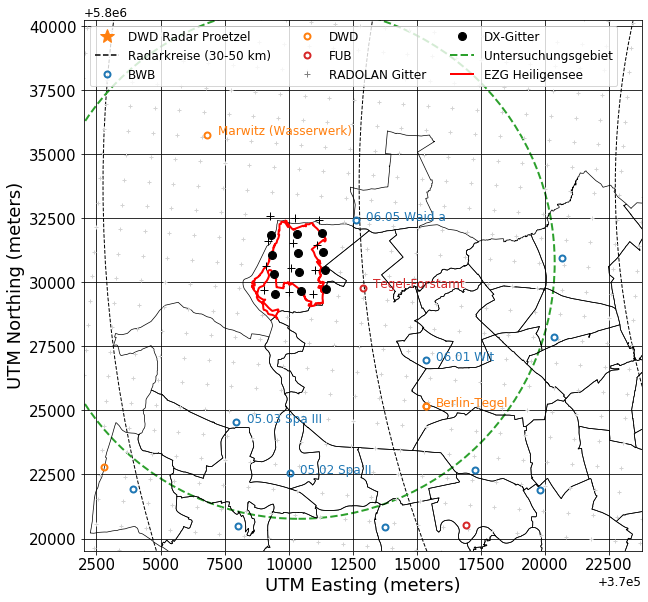

In [22]:
plt.rc('font', **{'size'   : 12})

fig = plt.figure(figsize=(10,10))

xoffset = 370000
yoffset = 5800000

ax = fig.add_subplot(111, aspect="equal")
#pm = plt.pcolormesh(x_rw, y_rw, np.ones((900,900)), 
#                    facecolor="None", edgecolor="grey", cmap=plt.cm.gist_gray, vmax=1, linewidth=0.1)
plt.plot(x_rw, y_rw, "k+", color="lightgray", ms=4)
site_xy = wradlib.georef.reproject(site, projection_target=proj)
plt.plot(site_xy[0], site_xy[1], "b*", ms=14, mfc="tab:orange", mec="tab:orange", label="DWD Radar Proetzel")
for rad in np.arange(1,7)*10000:
    circle = plt.Circle(site_xy[0:2], radius=rad, facecolor="None", edgecolor="black", ls="dashed")
    ax.add_artist(circle)
#wradlib.vis.plot_ppi_crosshair(site=site, ranges=[60000,], angles=[90,], proj=proj)
#wradlib.vis.plot_ppi_crosshair(site=site, ranges=np.arange(1,6)*10000,
#                               angles=[90], proj=proj,
#                               line=dict(color='none'),
#                               circle={'edgecolor': 'blue', "linewidth": 1., "linestyle":"-"})
ax.plot([], [], ms=0, color="black", ls="--", label="Radarkreise (30-50 km)")
#cb = plt.colorbar(pm, shrink=0.5)
wradlib.vis.add_lines(ax, borders, color='black', lw=0.7)
plt.plot(bwbg.x, bwbg.y, "go", markerfacecolor="None", mec="tab:blue", mew=2, label="BWB")
plt.plot(dwdg.x, dwdg.y, "go", markerfacecolor="None", mec="tab:orange", mew=2, label="DWD")
plt.plot(fug.x,  fug.y,  "go", markerfacecolor="None", mec="tab:red", mew=2, label="FUB")

wradlib.vis.add_lines(ax, heiligensee, color='red', lw=2, label="EZG Heiligensee")

plt.grid(color="black")
plt.xlabel("UTM Easting (meters)", fontsize=18)
plt.ylabel("UTM Northing (meters)", fontsize=18)
bufr = 10000

ax.tick_params(labelsize=15)
ax.plot([], [], "k+", color="gray", label="RADOLAN Gitter")

# ax.add_patch(
#     plt.Rectangle((bbox_tegel[0], bbox_tegel[2]),
#                   bbox_tegel[1] - bbox_tegel[0],
#                   bbox_tegel[3] - bbox_tegel[2], fill=False,
#                   edgecolor='blue', linewidth=2)
# )

plt.plot(dwdg_all.loc[430].x, dwdg_all.loc[430].y, marker="o", linewidth=0, mew=2, mec="tab:orange", mfc="None")
# plt.plot(fug.loc['Tegel-Forstamt'].x, fug.loc['Tegel-Forstamt'].y, marker="o", linewidth=0, ms=12, mec="blue", mew=2, mfc="None")


#bwbg_close = ['06.05 Waid a', '16.09 Bla', '06.01 Wit', '05.01 Spa I', '05.02 Spa II', '05.03 Spa III',
# '05.19 Spa V c', '14.02 Bln IV', '04.17 Bln IX','04.17 Bln IX', '16.06 Ros', '04.01 Chb I']

bwbg_close = ['06.05 Waid a', '06.01 Wit', '05.02 Spa II', '05.03 Spa III']

dwdg_close = [3205, 430]

fug_close = ["Tegel-Forstamt"]

for id in bwbg_close:
    plt.text(bwbg.loc[id].x+400, bwbg.loc[id].y, id, color="tab:blue", horizontalalignment='left')

for id in dwdg_close:
    plt.text(dwdg_all.loc[id].x+400, dwdg_all.loc[id].y, dwdg_all.loc[id]["name"], color="tab:orange", horizontalalignment='left')

for id in fug_close:
    plt.text(fug.loc[id].x+400, fug.loc[id].y, id, color="tab:red", horizontalalignment='left')

mask_heiligensee = (x_ry > bbox_heiligensee[0]) & (x_ry < bbox_heiligensee[1]) & \
(y_ry > bbox_heiligensee[2]+200) & (y_ry < bbox_heiligensee[3]+200)
plt.plot(x_rw[mask_heiligensee], y_rw[mask_heiligensee], "k+", color="black", ms=8)

x_dx = xyz_dx[...,0].ravel()
y_dx = xyz_dx[...,1].ravel()
dx_mask_heiligensee = (x_dx > bbox_heiligensee[0]) & (x_dx < bbox_heiligensee[1]+200) & \
(y_dx > bbox_heiligensee[2]+500) & (y_dx < bbox_heiligensee[3])
plt.plot(x_dx[dx_mask_heiligensee], y_dx[dx_mask_heiligensee], "ko", color="black", ms=8, label="DX-Gitter")


plt.xlim(bbox[0]+5000, bbox[1]-22000)
plt.ylim(bbox[2]+20000, bbox[3]+3000)

circle = plt.Circle([x_dx[dx_mask_heiligensee].mean(), y_dx[dx_mask_heiligensee].mean()],
                    radius=10000, facecolor="None", edgecolor="tab:green", ls="dashed", lw=2)
ax.add_artist(circle)
ax.plot([], [], ms=0, color="tab:green", lw=2, ls="--", label="Untersuchungsgebiet")

plt.ticklabel_format(axis="x", useOffset=xoffset)
plt.ticklabel_format(axis="y", useOffset=yoffset)
plt.legend(loc="upper left", fontsize=12, ncol=3)
#plt.title("DX")

plt.savefig("docs/report/setup2017.png", dpi=300, bbox_inches="tight")

In [23]:
tstart = "2017-06-29 09:00:00"
tend   = "2017-06-30 09:00:00"

In [24]:
fu = fu[tstart:tend]
dwd = dwd[tstart:tend]
bwb = bwb[tstart:tend]

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


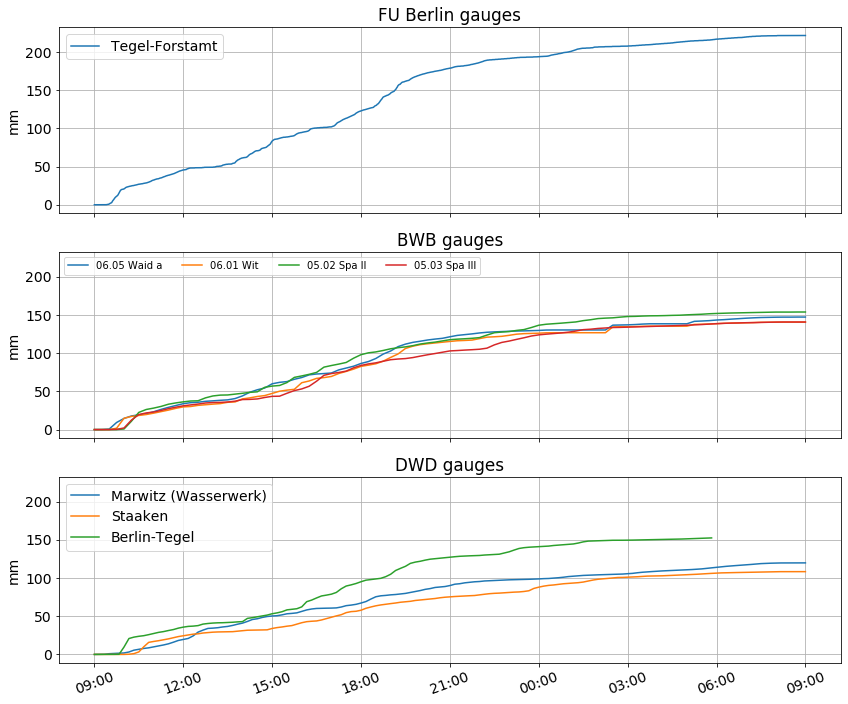

In [25]:
plt.rc('font', **{'size'   : 14})

fig, ax = plt.subplots(nrows=3, figsize=(12,10), sharex=True, sharey=True)
ax = ax.ravel()

plt.sca(ax[0])
tmp = fu
for id in fug_close:
    plt.plot(tmp.index, tmp[id].cumsum(), label=id)
plt.title("FU Berlin gauges")
plt.ylabel("mm")
plt.grid()
plt.legend()
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=20)

plt.sca(ax[1])
tmp = bwb
for id in bwbg_close:
    plt.plot(tmp.index, tmp[id].cumsum(), label=id)
plt.title("BWB gauges")
plt.ylabel("mm")
plt.grid()
plt.legend(ncol=5, fontsize=10, loc="upper left")
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#plt.xticks(rotation=20)

plt.sca(ax[2])
tmp = dwd
for id in [3205, 4637,430]:
    plt.plot(tmp.index, tmp[id].cumsum(), label=dwdg_all.loc[id]["name"])
plt.title("DWD gauges")
plt.ylabel("mm")
plt.grid()
plt.legend(loc="upper left")
ax[2].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=20)

plt.tight_layout()
plt.savefig("docs/events/gauges_2017.png", dpi=200, bbox_inches="tight")

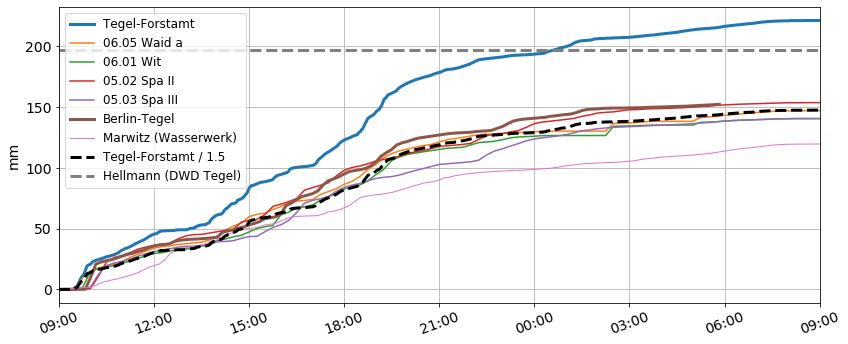

In [26]:
plt.rc('font', **{'size'   : 14})

fig, ax = plt.subplots(figsize=(12,5))

tmp = fu
for id in ["Tegel-Forstamt"]:
    plt.plot(tmp.index, tmp[id].cumsum(), label=id, lw=3)
plt.ylabel("mm")
plt.grid()


tmp = bwb
for id in bwbg_close:
    plt.plot(tmp.index, tmp[id].cumsum(), label=id)
plt.ylabel("mm")
plt.grid()


tmp = dwd
for id in [430, 3205]:
    if id==430:
        lw=3
    else:
        lw=1
    plt.plot(tmp.index, tmp[id].cumsum(), label=dwdg_all.loc[id]["name"], lw=lw)
plt.ylabel("mm")
plt.grid()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=20)

plt.plot(fu.index, fu["Tegel-Forstamt"].cumsum() / 1.5, lw=3, color="black", ls="--", label="Tegel-Forstamt / 1.5")

plt.axhline(197, ls="--", color="grey", lw=3, label="Hellmann (DWD Tegel)")

plt.legend(loc="upper left", fontsize=12)

plt.xlim(dt.datetime(2017,6,29,9), dt.datetime(2017,6,30,9))
plt.tight_layout()
plt.savefig("docs/report/gauges_2017.png", dpi=200, bbox_inches="tight")

In [222]:
0.67*225

150.75

### Radardaten laden und prozessieren

In [27]:
dtimes = wradlib.util.from_to(tstart, tend, 300)
# tmpg = gdata[starts[eventix]:ends[eventix]]
# tmpdwd = dwd[starts[eventix]:ends[eventix]]
# tmpdwdg = dwdg.copy()
# # deal with NaN
# for id in dwdg.index:
#     if len(np.where(np.isnan(tmpdwd[id]))[0]) > len(tmpdwd)*0.05:
#         tmpdwd = tmpdwd.drop([id], axis=1)
#         tmpdwdg = tmpdwdg.drop([id])

In [28]:
def proc_dx(dtimes, dxdirpattern):
    dbz = np.zeros((len(dtimes), len(az), len(r))) * np.nan
    for i, dtime in enumerate(dtimes):
        #dxpath = "/media/x/data/radar/dx/pro/DX-pro_201906/DX-pro_20190610/raa00-dx_10392-1906100000-pro---bin"
        #          /media/x/data/radar/dx/pro/DX-pro_201906/DX-pro_20190606/raa00-dx_10392-1906061200-pro---bin
        fpath = dxdirpattern % dtime.strftime("%y%m%d%H%M")
        try:
            data, meta = wradlib.io.read_dx(fpath)
            dbz[i] = data
            print(".", end="")
        except:
            print("Could not read: %s" % fpath)
            dbz[i] = 0
    # to precipitation depth
    dxprec = h.dbz2depth(dbz)
    pia = wradlib.atten.correct_attenuation_constrained(dbz, a_max=1.67e-4, a_min=2.33e-5, n_a=100,
                                                        b_max=0.7, b_min=0.65, n_b=6, gate_length=1.,
                                                        constraints=[wradlib.atten.constraint_dbz,
                                                                     wradlib.atten.constraint_pia],
                                                        constraint_args=[[59.0], [40.0]])
#    pia = wradlib.atten.correct_attenuation_hb(dbz, mode="nan")
    dxprec2 = h.dbz2depth(dbz + pia)
    print("")
    return(dxprec, dxprec2)

In [29]:
def proc_dx(dtimes, dxdirpattern):
    dbz = np.zeros((len(dtimes), len(az), len(r))) * np.nan
    for i, dtime in enumerate(dtimes):
        #dxpath = "/media/x/data/radar/dx/pro/DX-pro_201906/DX-pro_20190610/raa00-dx_10392-1906100000-pro---bin"
        #          /media/x/data/radar/dx/pro/DX-pro_201906/DX-pro_20190606/raa00-dx_10392-1906061200-pro---bin
        fpath = dxdirpattern % dtime.strftime("%y%m%d%H%M")
        try:
            data, meta = wradlib.io.read_dx(fpath)
            dbz[i] = data
            print(".", end="")
        except:
            print("Could not read: %s" % fpath)
            dbz[i] = 0
    return dbz

In [30]:
dbz = proc_dx(dtimes, dxdirpattern)
dxprec = h.dbz2depth(dbz)

.................................................................................................................................................................................................................................................................................................

In [31]:
# to Z
tmp = wradlib.trafo.idecibel(dbz)
# to R
tmp2 = np.zeros(tmp.shape)
for i in range(len(tmp2)):
    tmp2[i] = wradlib.zr.z_to_r_enhanced(tmp[i])[0]
# to depth
dxprec = wradlib.trafo.r_to_depth(tmp2, 300)

In [32]:
pia = wradlib.atten.correct_attenuation_constrained(dbz, a_max=1.67e-4, a_min=2.33e-5, n_a=100,
                                                    b_max=0.7, b_min=0.65, n_b=6, gate_length=1.,
                                                    constraints=[wradlib.atten.constraint_dbz,
                                                                 wradlib.atten.constraint_pia],
                                                    constraint_args=[[59.0], [20.0]], sector_thr=10)
dxprec2 = h.dbz2depth(dbz + pia)

/home/maik/miniconda3/envs/cs/lib/python3.7/site-packages/wradlib/trafo.py:142: RuntimeWarning: overflow encountered in power
  return 10. ** (x / 10.)


In [69]:
# to Z
tmp = wradlib.trafo.idecibel(dbz+pia)
# to R
tmp2 = np.zeros(tmp.shape)
for i in range(len(tmp2)):
    tmp2[i] = wradlib.zr.z_to_r_enhanced(tmp[i])[0]
# to depth
dxprec2 = wradlib.trafo.r_to_depth(tmp2, 300)

In [144]:
k=5

In [145]:
# compute the KDTree
tree_dx = KDTree(list(zip(xyz_dx[...,0].ravel(), xyz_dx[...,1].ravel())))
#tree_dx = KDTree(np.array([xyz_dx[...,0].ravel(), xyz_dx[...,1].ravel()]).T)
# query the tree for nearest neighbours
dists_dx_bwb, ix_dx_bwb = tree_dx.query(list(zip(bwbg.loc[bwbg_close].x, bwbg.loc[bwbg_close].y)), k=k)
dists_dx_fu, ix_dx_fu = tree_dx.query(list(zip(fug.loc[fug_close].x, fug.loc[fug_close].y)), k=k)                                                                                 
dists_dx_dwd, ix_dx_dwd = tree_dx.query(list(zip(dwdg_all.loc[dwdg_close].x, dwdg_all.loc[dwdg_close].y)), k=k)

In [146]:
def proc_rw(dtimes, rwdirpattern):
    tstart_rw = dtimes[0] + dt.timedelta(seconds=50*60)#.replace(minute=0) - dt.timedelta(seconds=10*60)
    tend_rw = dtimes[-1]#.replace(minute=0) + dt.timedelta(seconds=10*60)
    dtimes_rw = wradlib.util.from_to(tstart_rw, tend_rw, 3600)
    rwprec = np.zeros((len(dtimes_rw), 1100, 900)) * np.nan
    for i, dtime in enumerate(dtimes_rw):
        fpath = rwdirpattern % dtime.strftime("%y%m%d%H%M")
        try:
            data, meta = wradlib.io.read_radolan_composite(fpath, missing=np.nan)
            rwprec[i] = data
            print(".", end="")
        except:
            print("Could not read: %s" % fpath)
    print("")
    return rwprec, dtimes_rw

In [147]:
def proc_ry(dtimes, rydirpattern):
    ryprec = np.zeros((len(dtimes), 1100, 900)) * np.nan
    for i, dtime in enumerate(dtimes):
        fpath = rydirpattern % dtime.strftime("%y%m%d%H%M")
        try:
            data, meta = wradlib.io.read_radolan_composite(fpath, missing=np.nan)
            ryprec[i] = data
            print(".", end="")
        except:
            print("Could not read: %s" % fpath)
    print("")
    return ryprec

In [148]:
# Rain gauge indices for good and bad gauges
# gix = np.array(gauges.flag=="")
# gix2 = np.array(gauges.veg=="geprüft") & gix
# bix = ~gix2
# gix = np.where(gix)[0]
gix = np.arange(len(bwbg))
bix = ~gix
gix = np.where(gix)[0]

In [149]:
# bestgdx = np.argmin(np.abs(np.sum(dxprec.reshape( (len(dtimes), -1))[:,ix_dx], axis=0) - np.array(np.sum(tmpg, axis=0)).reshape((50,1))), axis=1)
# bestgdx2= np.argmin(np.abs(np.sum(dxprec2.reshape((len(dtimes), -1))[:,ix_dx], axis=0) - np.array(np.sum(tmpg, axis=0)).reshape((50,1))), axis=1)
# # DWD gauges
# dwdbestgdx = np.argmin(np.abs(np.sum(dxprec.reshape( (len(dtimes), -1))[:,dwdix_dx], axis=0) - np.array(np.sum(tmpdwd, axis=0)).reshape((len(tmpdwdg),1))), axis=1)
# dwdbestgdx2= np.argmin(np.abs(np.sum(dxprec2.reshape((len(dtimes), -1))[:,dwdix_dx], axis=0) - np.array(np.sum(tmpdwd, axis=0)).reshape((len(tmpdwdg),1))), axis=1)

In [150]:
# dx_at_gauge  = dxprec.reshape ((len(dtimes), -1))[np.arange(len(dtimes))[:,None],ix_dx[np.arange(len(ix_dx)),bestgdx]]
# dx2_at_gauge = dxprec2.reshape((len(dtimes), -1))[np.arange(len(dtimes))[:,None],ix_dx[np.arange(len(ix_dx)),bestgdx2]]
# # DWD
# dx_at_dwdgauge = dxprec.reshape((len(dtimes), -1))[np.arange(len(dtimes))[:,None],dwdix_dx[np.arange(len(dwdix_dx)),dwdbestgdx]]
# dx2_at_dwdgauge = dxprec2.reshape((len(dtimes), -1))[np.arange(len(dtimes))[:,None],dwdix_dx[np.arange(len(dwdix_dx)),dwdbestgdx2]]

In [151]:
# dx_at_gauge = np.median(dxprec.reshape((len(dtimes), -1))[:,ix_dx], axis=2)
# dx2_at_gauge = np.median(dxprec2.reshape((len(dtimes), -1))[:,ix_dx], axis=2)

In [152]:
rwprec, dtimes_rw = proc_rw(dtimes, rwdirpattern)

........................


In [153]:
ryprec = proc_ry(dtimes, rydirpattern)

.................................................................................................................................................................................................................................................................................................


In [154]:
# compute the KDTree
tree_rw = KDTree(list(zip(x_rw.ravel(), y_rw.ravel())))
# query the tree for nearest neighbours
dists_rw_bwb, ix_rw_bwb = tree_rw.query(list(zip(bwbg.loc[bwbg_close].x, bwbg.loc[bwbg_close].y)), k=k)
dists_rw_fu, ix_rw_fu = tree_rw.query(list(zip(fug.loc[fug_close].x, fug.loc[fug_close].y)), k=k)
dists_rw_dwd, ix_rw_dwd = tree_rw.query(list(zip(dwdg_all.loc[dwdg_close].x, dwdg_all.loc[dwdg_close].y)), k=k)

In [155]:
# compute the KDTree
tree_ry = KDTree(list(zip(x_ry.ravel(), y_ry.ravel())))
# query the tree for nearest neighbours
dists_ry, ix_ry_bwb = tree_ry.query(list(zip(bwbg.loc[bwbg_close].x, bwbg.loc[bwbg_close].y)), k=k)
dists_ry_fu, ix_ry_fu = tree_ry.query(list(zip(fug.loc[fug_close].x, fug.loc[fug_close].y)), k=k)
dists_ry_dwd, ix_ry_dwd = tree_ry.query(list(zip(dwdg_all.loc[dwdg_close].x, dwdg_all.loc[dwdg_close].y)), k=k)

In [156]:
ix_rw_hlg = np.where(mask_heiligensee.ravel())[0]
ix_ry_hlg = np.where(mask_heiligensee.ravel())[0]
ix_dx_hlg = np.where(dx_mask_heiligensee.ravel())[0]

In [157]:
# RW
rw_at_bwb = np.median(rwprec.reshape((len(dtimes_rw), -1))[:,ix_rw_bwb], axis=2)
rw_at_fu  = np.median(rwprec.reshape((len(dtimes_rw), -1))[:,ix_rw_fu ], axis=2)
rw_at_dwd = np.median(rwprec.reshape((len(dtimes_rw), -1))[:,ix_rw_dwd], axis=2)
rw_at_hlg = np.median(rwprec.reshape((len(dtimes_rw), -1))[:,ix_rw_hlg], axis=1)
# RY
ry_at_bwb = np.median(ryprec.reshape((len(dtimes),    -1))[:,ix_ry_bwb], axis=2)
ry_at_fu  = np.median(ryprec.reshape((len(dtimes),    -1))[:,ix_ry_fu ], axis=2)
ry_at_dwd = np.median(ryprec.reshape((len(dtimes),    -1))[:,ix_ry_dwd], axis=2)
ry_at_hlg = np.median(ryprec.reshape((len(dtimes),    -1))[:,ix_ry_hlg], axis=1)
# DX
dx_at_bwb = np.median(dxprec.reshape((len(dtimes),    -1))[:,ix_dx_bwb], axis=2)
dx_at_fu  = np.median(dxprec.reshape((len(dtimes),    -1))[:,ix_dx_fu ], axis=2)
dx_at_dwd = np.median(dxprec.reshape((len(dtimes),    -1))[:,ix_dx_dwd], axis=2)
dx_at_hlg = np.median(dxprec.reshape((len(dtimes),    -1))[:,ix_dx_hlg], axis=1)
# DX2
dx2_at_bwb = np.median(dxprec2.reshape((len(dtimes),    -1))[:,ix_dx_bwb], axis=2)
dx2_at_fu  = np.median(dxprec2.reshape((len(dtimes),    -1))[:,ix_dx_fu ], axis=2)
dx2_at_dwd = np.median(dxprec2.reshape((len(dtimes),    -1))[:,ix_dx_dwd], axis=2)
dx2_at_hlg = np.median(dxprec2.reshape((len(dtimes),    -1))[:,ix_dx_hlg], axis=1)


In [158]:
# #rw_at_gauge = np.median(rwprec.reshape((len(dtimes_rw), -1))[:,ix_rw], axis=2)
# # best match
# bestgrw = np.argmin(np.abs(np.sum(rwprec.reshape( (len(dtimes_rw), -1))[:,ix_rw], axis=0) - np.array(np.sum(bwb, axis=0)).reshape((50,1))), axis=1)
# rw_at_gauge = rwprec.reshape((len(dtimes_rw), -1))[np.arange(len(dtimes_rw))[:,None],ix_rw[np.arange(len(ix_rw)),bestgrw]]
# # DWD
# dwddists_rw, dwdix_rw = tree_rw.query(list(zip(dwdg.x, dwdg.y)), k=9)
# dwdbestgrw = np.argmin(np.abs(np.sum(rwprec.reshape( (len(dtimes_rw), -1))[:,dwdix_rw], axis=0) - np.array(np.sum(dwd, axis=0)).reshape((len(tmpdwdg),1))), axis=1)
# rw_at_dwdgauge = rwprec.reshape((len(dtimes_rw), -1))[np.arange(len(dtimes_rw))[:,None],dwdix_rw[np.arange(len(dwdix_rw)),dwdbestgrw]]

# Interpolation der Messungen an den Niederschlagsschreibern

## Kreuzvalidierung

In [159]:
# # Interpolation using all gauges
# obs_coords = np.array(gauges.loc[:,["x", "y"]]).astype("f4")
# rad_coords = xyz_dx[...,0:2].reshape((-1,2))

# go_all = wradlib.adjust.GageOnly(obs_coords, rad_coords, nnear_raws=9)
# gosum_all_obs, gosum_all_est = go_all.xvalidate(np.array(tmpg.sum()[:]),
#                                                 dxprec.sum(axis=0).ravel())
# #gosum_all_obs, gosum_all_est = go_all.xvalidate(np.array(gageprec[:]), 
# #                                                np.ones(len(gageprec[:])))

In [160]:
# #Interpolation using "good" gauges
# obs_coords_gix = np.array(gauges.loc[gauges.index[gix],["x", "y"]]).astype("f4")

# go_gix = wradlib.adjust.GageOnly(obs_coords_gix, rad_coords, nnear_raws=9)
# gosum_gix_obs, gosum_gix_est = go_gix.xvalidate(np.array(tmpg.sum()[gix]),
#                                                dxprec.sum(axis=0).ravel())

In [161]:
# # go_all_5min = np.zeros(gdata.shape)
# # for i in range(len(go_all_5min)):
# #     _, go_all_5min[i] = go_all.xvalidate(np.array(gdata.iloc[i]), dxprec[i].ravel())

# go_all_5min = np.zeros(tmpg.shape)
# for i in range(len(go_all_5min)):
#     _, go_all_5min[i] = go_all.xvalidate(np.array(tmpg.iloc[i]), dxprec[i].ravel())    

## Interpolation auf Gitter

In [162]:
# # Target coordinates
# xtrg = np.arange(bbox[0]-1000, bbox[1]+2000, 1000)
# ytrg = np.arange(bbox[2]-1000, bbox[3]+2000, 1000)
# trg = wradlib.util.gridaspoints(ytrg, xtrg)
# #trg = np.meshgrid(xtrg, ytrg)
# #trg = np.vstack( (trg[0].ravel(), trg[1].ravel()) ).T

In [163]:
# # Interpolation objects
# # idw = wradlib.ipol.Idw(obs_coords_gix, trg)
# # ip = idw(np.array(gdata[gix].sum())).reshape((len(ytrg), len(xtrg)))
# idw = wradlib.ipol.Idw(obs_coords_gix, trg)
# ip = idw(np.array(tmpg.iloc[:,gix].sum())).reshape((len(ytrg), len(xtrg)))

## Flächenhafte Darstellung aller Produkte

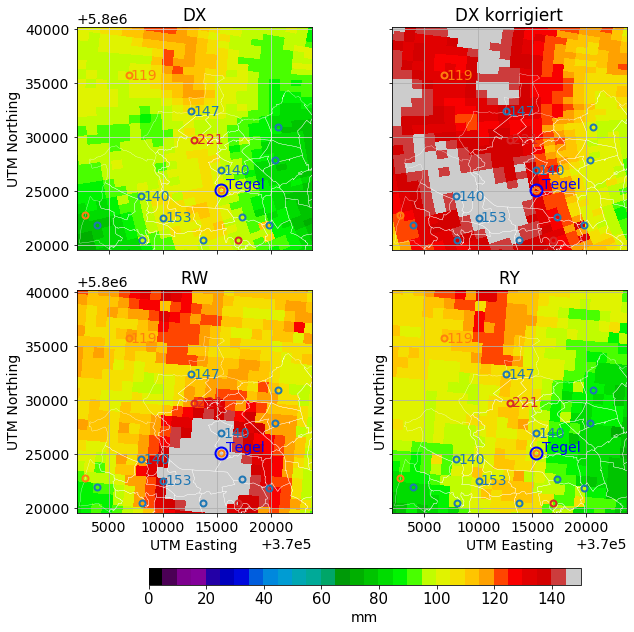

In [164]:
plt.rc('font', **{'size'   : 14})

gridcolor = "lightgray"
linecolor = "white"
#fontsize = 18

cmap = plt.cm.nipy_spectral#plt.cm.magma

bounds = np.arange(0, 155, 5)
lenmap = len(bounds) - 1
colornums = [int(i*(cmap.N-1)/(lenmap-1)) for i in (np.arange(lenmap))]
colors = [cmap(i) for i in colornums]
listedcmap = mpl.colors.ListedColormap(colors)
norm = BoundaryNorm(bounds, listedcmap.N)

fig, axs = plt.subplots(figsize=(10,8), nrows=2, ncols=2, sharex=True, sharey=True)
axs = axs.ravel()

axi = 0
plt.sca(axs[axi])
ax = axs[axi]
ax.set_aspect("equal")
ax, pm1 = wradlib.vis.plot_ppi(dxprec.sum(axis=0), r=r, az=az, site=site, 
                             proj=proj, cmap=plt.cm.nipy_spectral, vmin=0, vmax=85, ax=ax)
ax, pm = wradlib.vis.plot_ppi(dxprec.sum(axis=0), ax=ax, r=r, az=az, site=site, 
                              proj=proj, cmap=listedcmap, norm=norm)
wradlib.vis.add_lines(ax, borders, color=linecolor, lw=0.3)
plt.grid(color=gridcolor)
#plt.xlabel("UTM Easting", fontsize=fontsize)
plt.ylabel("UTM Northing")#, fontsize=fontsize)
plt.xlim(bbox[0], bbox[1])
plt.ylim(bbox[2], bbox[3])
plt.title("DX")#, fontsize=fontsize)
for id in bwbg_close:
    plt.text(bwbg.loc[id].x+200, bwbg.loc[id].y, "%d" % bwb.loc[tstart:tend, id].sum(),
             horizontalalignment='left', verticalalignment='center', 
             color="tab:blue", fontsize=14)
for id in dwdg_close:
    if id==430:
        continue
    plt.text(dwdg.loc[id, "x"]+200, dwdg.loc[id, "y"], "%d" % dwd[tstart:tend].sum()[id],
             horizontalalignment='left', verticalalignment='center', 
             color="tab:orange", fontsize=14)
for id in fug_close:
    plt.text(fug.loc[id, "x"]+200, fug.loc[id, "y"], "%d" % fu[tstart:tend].sum()[id],
             horizontalalignment='left', verticalalignment='center', 
             color="tab:red", fontsize=14)
plt.plot(dwdg_all.loc[430].x, dwdg_all.loc[430].y, marker="o", linewidth=0, ms=12, mec="blue", mew=2, mfc="None")
plt.text(dwdg_all.loc[430].x+500, dwdg_all.loc[430].y+100, "Tegel", color="blue", horizontalalignment='left')
plt.ticklabel_format(axis="x", useOffset=xoffset)
plt.ticklabel_format(axis="y", useOffset=yoffset)
plt.plot(bwbg.x, bwbg.y, "go", markerfacecolor="None", mec="tab:blue", mew=2, label="BWB")
plt.plot(dwdg.x, dwdg.y, "go", markerfacecolor="None", mec="tab:orange", mew=2, label="DWD")
plt.plot(fug.x,  fug.y,  "go", markerfacecolor="None", mec="tab:red", mew=2, label="FUB")


axi = 1
plt.sca(axs[axi])
ax = axs[axi]
ax.set_aspect("equal")
ax, pm = wradlib.vis.plot_ppi(dxprec2.sum(axis=0), ax=ax, r=r, az=az, site=site, 
                              proj=proj, cmap=listedcmap, norm=norm)
wradlib.vis.add_lines(ax, borders, color=linecolor, lw=0.3)
plt.grid()
#plt.xlabel("UTM Easting")
#plt.ylabel("UTM Northing")
#plt.xlim(bbox[0], bbox[1])
#plt.ylim(bbox[2], bbox[3])
plt.title("DX korrigiert")#, fontsize=fontsize)
for id in bwbg_close:
    plt.text(bwbg.loc[id].x+200, bwbg.loc[id].y, "%d" % bwb.loc[tstart:tend, id].sum(),
             horizontalalignment='left', verticalalignment='center', 
             color="tab:blue", fontsize=14)
for id in dwdg_close:
    if id==430:
        continue
    plt.text(dwdg.loc[id, "x"]+200, dwdg.loc[id, "y"], "%d" % dwd[tstart:tend].sum()[id],
             horizontalalignment='left', verticalalignment='center', 
             color="tab:orange", fontsize=14)
for id in fug_close:
    plt.text(fug.loc[id, "x"]+200, fug.loc[id, "y"], "%d" % fu[tstart:tend].sum()[id],
             horizontalalignment='left', verticalalignment='center', 
             color="tab:red", fontsize=14)
plt.plot(dwdg_all.loc[430].x, dwdg_all.loc[430].y, marker="o", linewidth=0, ms=12, mec="blue", mew=2, mfc="None")
plt.text(dwdg_all.loc[430].x+500, dwdg_all.loc[430].y+100, "Tegel", color="blue", horizontalalignment='left')
plt.ticklabel_format(axis="x", useOffset=xoffset)
plt.ticklabel_format(axis="y", useOffset=yoffset)
plt.plot(bwbg.x, bwbg.y, "go", markerfacecolor="None", mec="tab:blue", mew=2, label="BWB")
plt.plot(dwdg.x, dwdg.y, "go", markerfacecolor="None", mec="tab:orange", mew=2, label="DWD")
plt.plot(fug.x,  fug.y,  "go", markerfacecolor="None", mec="tab:red", mew=2, label="FUB")


axi = 2
plt.sca(axs[axi])
ax = axs[axi]
ax.set_aspect("equal")
pm = plt.pcolormesh(x_rw, y_rw, np.ma.masked_invalid(rwprec.sum(axis=0)), cmap=listedcmap, norm=norm)
wradlib.vis.add_lines(ax, borders, color=linecolor, lw=0.3)
plt.grid()
plt.xlabel("UTM Easting")#, fontsize=fontsize)
plt.ylabel("UTM Northing")#, fontsize=fontsize)
plt.xlim(bbox[0], bbox[1])
plt.ylim(bbox[2], bbox[3])
plt.title("RW")#, fontsize=fontsize)
for id in bwbg_close:
    plt.text(bwbg.loc[id].x+200, bwbg.loc[id].y, "%d" % bwb.loc[tstart:tend, id].sum(),
             horizontalalignment='left', verticalalignment='center', 
             color="tab:blue", fontsize=14)
for id in dwdg_close:
    if id==430:
        continue
    plt.text(dwdg.loc[id, "x"]+200, dwdg.loc[id, "y"], "%d" % dwd[tstart:tend].sum()[id],
             horizontalalignment='left', verticalalignment='center', 
             color="tab:orange", fontsize=14)
for id in fug_close:
    plt.text(fug.loc[id, "x"]+200, fug.loc[id, "y"], "%d" % fu[tstart:tend].sum()[id],
             horizontalalignment='left', verticalalignment='center', 
             color="tab:red", fontsize=14)
plt.plot(dwdg_all.loc[430].x, dwdg_all.loc[430].y, marker="o", linewidth=0, ms=12, mec="blue", mew=2, mfc="None")
plt.text(dwdg_all.loc[430].x+500, dwdg_all.loc[430].y+100, "Tegel", color="blue", horizontalalignment='left')
plt.ticklabel_format(axis="x", useOffset=xoffset)
plt.ticklabel_format(axis="y", useOffset=yoffset)
plt.plot(bwbg.x, bwbg.y, "go", markerfacecolor="None", mec="tab:blue", mew=2, label="BWB")
plt.plot(dwdg.x, dwdg.y, "go", markerfacecolor="None", mec="tab:orange", mew=2, label="DWD")
plt.plot(fug.x,  fug.y,  "go", markerfacecolor="None", mec="tab:red", mew=2, label="FUB")


axi = 3
plt.sca(axs[axi])
ax = axs[axi]
ax.set_aspect("equal")
pm = plt.pcolormesh(x_ry, y_ry, np.ma.masked_invalid(ryprec.sum(axis=0)), cmap=listedcmap, norm=norm)
wradlib.vis.add_lines(ax, borders, color=linecolor, lw=0.3)
plt.grid()
plt.xlabel("UTM Easting")#, fontsize=fontsize)
plt.ylabel("UTM Northing")#, fontsize=fontsize)
plt.xlim(bbox[0]+5000, bbox[1]-22000)
plt.ylim(bbox[2]+20000, bbox[3]+3000)
plt.title("RY")#, fontsize=fontsize)
for id in bwbg_close:
    plt.text(bwbg.loc[id].x+200, bwbg.loc[id].y, "%d" % bwb.loc[tstart:tend, id].sum(),
             horizontalalignment='left', verticalalignment='center', 
             color="tab:blue", fontsize=14)
for id in dwdg_close:
    if id==430:
        continue
    plt.text(dwdg.loc[id, "x"]+200, dwdg.loc[id, "y"], "%d" % dwd[tstart:tend].sum()[id],
             horizontalalignment='left', verticalalignment='center', 
             color="tab:orange", fontsize=14)
for id in fug_close:
    plt.text(fug.loc[id, "x"]+200, fug.loc[id, "y"], "%d" % fu[tstart:tend].sum()[id],
             horizontalalignment='left', verticalalignment='center', 
             color="tab:red", fontsize=14)
plt.plot(dwdg_all.loc[430].x, dwdg_all.loc[430].y, marker="o", linewidth=0, ms=12, mec="blue", mew=2, mfc="None")
plt.text(dwdg_all.loc[430].x+500, dwdg_all.loc[430].y+100, "Tegel", color="blue", horizontalalignment='left')
plt.ticklabel_format(axis="x", useOffset=xoffset)
plt.ticklabel_format(axis="y", useOffset=yoffset)
plt.plot(bwbg.x, bwbg.y, "go", markerfacecolor="None", mec="tab:blue", mew=2, label="BWB")
plt.plot(dwdg.x, dwdg.y, "go", markerfacecolor="None", mec="tab:orange", mew=2, label="DWD")
plt.plot(fug.x,  fug.y,  "go", markerfacecolor="None", mec="tab:red", mew=2, label="FUB")

plt.tight_layout()
#fig.subplots_adjust(bottom=0.01)
cbar_ax = fig.add_axes([0.25, -0.03, 0.6, 0.03])
cb = fig.colorbar(pm, cax=cbar_ax, orientation="horizontal")
cb.set_label("mm")#, fontsize)#=fontsize)
cb.ax.tick_params(labelsize=15)

#plt.savefig("docs/events/rainmap_20170629.png", dpi=300, bbox_inches="tight")


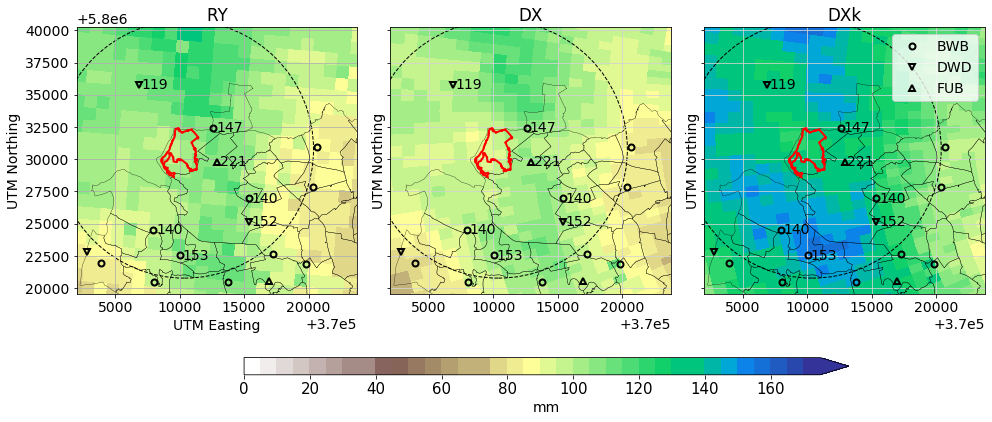

In [165]:
plt.rc('font', **{'size'   : 14})

gridcolor = "lightgray"
linecolor = "black"
#fontsize = 18

cmap = plt.cm.terrain_r# nipy_spectral#plt.cm.magma

bounds = np.arange(0, 180, 5)
lenmap = len(bounds) - 1
colornums = [int(i*(cmap.N-1)/(lenmap-1)) for i in (np.arange(lenmap))]
colors = [cmap(i) for i in colornums]
listedcmap = mpl.colors.ListedColormap(colors)
norm = BoundaryNorm(bounds, listedcmap.N)

fig, axs = plt.subplots(figsize=(14,8), nrows=1, ncols=3, sharex=True, sharey=True)
axs = axs.ravel()


axi = 0
plt.sca(axs[axi])
ax = axs[axi]
ax.set_aspect("equal")
pm = plt.pcolormesh(x_ry, y_ry, np.ma.masked_invalid(ryprec.sum(axis=0)), cmap=listedcmap, norm=norm)
wradlib.vis.add_lines(ax, borders, color=linecolor, lw=0.3)
wradlib.vis.add_lines(ax, heiligensee, color='red', lw=2)
plt.grid()
plt.xlabel("UTM Easting")#, fontsize=fontsize)
plt.ylabel("UTM Northing")#, fontsize=fontsize)
plt.xlim(bbox[0]+5000, bbox[1]-22000)
plt.ylim(bbox[2]+20000, bbox[3]+3000)
plt.title("RY")#, fontsize=fontsize)
for id in bwbg_close:
    plt.text(bwbg.loc[id].x+200, bwbg.loc[id].y, "%d" % bwb.loc[tstart:tend, id].sum(),
             horizontalalignment='left', verticalalignment='center', 
             color="black", fontsize=14)
for id in dwdg_close:
    plt.text(dwdg.loc[id, "x"]+200, dwdg.loc[id, "y"], "%d" % dwd[tstart:tend].sum()[id],
             horizontalalignment='left', verticalalignment='center', 
             color="black", fontsize=14)
for id in fug_close:
    plt.text(fug.loc[id, "x"]+200, fug.loc[id, "y"], "%d" % fu[tstart:tend].sum()[id],
             horizontalalignment='left', verticalalignment='center', 
             color="black", fontsize=14)
#plt.plot(dwdg_all.loc[430].x, dwdg_all.loc[430].y, marker="o", linewidth=0, ms=12, mec="blue", mew=2, mfc="None")
#plt.text(dwdg_all.loc[430].x+500, dwdg_all.loc[430].y+100, "Tegel", color="blue", horizontalalignment='left')
plt.ticklabel_format(axis="x", useOffset=xoffset)
plt.ticklabel_format(axis="y", useOffset=yoffset)
plt.plot(bwbg.x, bwbg.y, "go", markerfacecolor="None", mec="black", mew=2, label="BWB")
plt.plot(dwdg.x, dwdg.y, "gv", markerfacecolor="None", mec="black", mew=2, label="DWD")
plt.plot(fug.x,  fug.y,  "g^", markerfacecolor="None", mec="black", mew=2, label="FUB")
circle = plt.Circle([x_dx[dx_mask_heiligensee].mean(), y_dx[dx_mask_heiligensee].mean()],
                    radius=10000, facecolor="None", edgecolor="black", ls="dashed", lw=1)
ax.add_artist(circle)

axi = 1
plt.sca(axs[axi])
ax = axs[axi]
ax.set_aspect("equal")
ax, pm = wradlib.vis.plot_ppi(dxprec.sum(axis=0), ax=ax, r=r, az=az, site=site, 
                              proj=proj, cmap=listedcmap, norm=norm)
wradlib.vis.add_lines(ax, borders, color=linecolor, lw=0.3)
wradlib.vis.add_lines(ax, heiligensee, color='red', lw=2)
plt.grid(color=gridcolor)
#plt.xlabel("UTM Easting", fontsize=fontsize)
plt.ylabel("UTM Northing")#, fontsize=fontsize)
plt.xlim(bbox[0], bbox[1])
plt.ylim(bbox[2], bbox[3])
plt.title("DX")#, fontsize=fontsize)
for id in bwbg_close:
    plt.text(bwbg.loc[id].x+200, bwbg.loc[id].y, "%d" % bwb.loc[tstart:tend, id].sum(),
             horizontalalignment='left', verticalalignment='center', 
             color="black", fontsize=14)
for id in dwdg_close:
    plt.text(dwdg.loc[id, "x"]+200, dwdg.loc[id, "y"], "%d" % dwd[tstart:tend].sum()[id],
             horizontalalignment='left', verticalalignment='center', 
             color="black", fontsize=14)
for id in fug_close:
    plt.text(fug.loc[id, "x"]+200, fug.loc[id, "y"], "%d" % fu[tstart:tend].sum()[id],
             horizontalalignment='left', verticalalignment='center', 
             color="black", fontsize=14)
#plt.plot(dwdg_all.loc[430].x, dwdg_all.loc[430].y, marker="o", linewidth=0, ms=12, mec="blue", mew=2, mfc="None")
#plt.text(dwdg_all.loc[430].x+500, dwdg_all.loc[430].y+100, "Tegel", color="blue", horizontalalignment='left')
plt.ticklabel_format(axis="x", useOffset=xoffset)
plt.ticklabel_format(axis="y", useOffset=yoffset)
plt.plot(bwbg.x, bwbg.y, "go", markerfacecolor="None", mec="black", mew=2, label="BWB")
plt.plot(dwdg.x, dwdg.y, "gv", markerfacecolor="None", mec="black", mew=2, label="DWD")
plt.plot(fug.x,  fug.y,  "g^", markerfacecolor="None", mec="black", mew=2, label="FUB")
circle = plt.Circle([x_dx[dx_mask_heiligensee].mean(), y_dx[dx_mask_heiligensee].mean()],
                    radius=10000, facecolor="None", edgecolor="black", ls="dashed", lw=1)
ax.add_artist(circle)



axi = 2
plt.sca(axs[axi])
ax = axs[axi]
ax.set_aspect("equal")
ax, pm = wradlib.vis.plot_ppi(dxprec2.sum(axis=0), ax=ax, r=r, az=az, site=site, 
                              proj=proj, cmap=listedcmap, norm=norm)
wradlib.vis.add_lines(ax, borders, color=linecolor, lw=0.3)
wradlib.vis.add_lines(ax, heiligensee, color='red', lw=2)
plt.grid(color=gridcolor)
#plt.xlabel("UTM Easting", fontsize=fontsize)
plt.ylabel("UTM Northing")#, fontsize=fontsize)
plt.xlim(bbox[0], bbox[1])
plt.ylim(bbox[2], bbox[3])
plt.title("DXk")#, fontsize=fontsize)
for id in bwbg_close:
    plt.text(bwbg.loc[id].x+200, bwbg.loc[id].y, "%d" % bwb.loc[tstart:tend, id].sum(),
             horizontalalignment='left', verticalalignment='center', 
             color="black", fontsize=14)
for id in dwdg_close:
    plt.text(dwdg.loc[id, "x"]+200, dwdg.loc[id, "y"], "%d" % dwd[tstart:tend].sum()[id],
             horizontalalignment='left', verticalalignment='center', 
             color="black", fontsize=14)
for id in fug_close:
    plt.text(fug.loc[id, "x"]+200, fug.loc[id, "y"], "%d" % fu[tstart:tend].sum()[id],
             horizontalalignment='left', verticalalignment='center', 
             color="black", fontsize=14)
#plt.plot(dwdg_all.loc[430].x, dwdg_all.loc[430].y, marker="o", linewidth=0, ms=12, mec="blue", mew=2, mfc="None")
#plt.text(dwdg_all.loc[430].x+500, dwdg_all.loc[430].y+100, "Tegel", color="blue", horizontalalignment='left')
plt.ticklabel_format(axis="x", useOffset=xoffset)
plt.ticklabel_format(axis="y", useOffset=yoffset)
plt.plot(bwbg.x, bwbg.y, "go", markerfacecolor="None", mec="black", mew=2, label="BWB")
plt.plot(dwdg.x, dwdg.y, "gv", markerfacecolor="None", mec="black", mew=2, label="DWD")
plt.plot(fug.x,  fug.y,  "g^", markerfacecolor="None", mec="black", mew=2, label="FUB")
circle = plt.Circle([x_dx[dx_mask_heiligensee].mean(), y_dx[dx_mask_heiligensee].mean()],
                    radius=10000, facecolor="None", edgecolor="black", ls="dashed", lw=1)
ax.add_artist(circle)
plt.legend()



plt.xlim(bbox[0]+5000, bbox[1]-22000)
plt.ylim(bbox[2]+20000, bbox[3]+3000)

plt.tight_layout()
fig.subplots_adjust(bottom=0.01)
cbar_ax = fig.add_axes([0.25, 0.12, 0.6, 0.03])
cb = fig.colorbar(pm, cax=cbar_ax, orientation="horizontal")
cb.set_label("mm")#, fontsize)#=fontsize)
cb.ax.tick_params(labelsize=15)

plt.savefig("docs/report/rainmap_20170629.png", dpi=100, bbox_inches="tight")


### Diagnoseplot

In [166]:
def rmse2plot(x,y, maxval):
    plt.text(0.05*maxval, 0.9*maxval, "RMSE=%.2f mm" % h.rmse(x, y),
             fontsize=12, backgroundcolor="white")

### Kumulativer Niederschlag über die Zeit

In [167]:
# RW
dfrwbwb = pd.DataFrame(rw_at_bwb, index=dtimes_rw)
dfrwbwb.columns = bwbg_close

In [168]:
# RY
dfrybwb = pd.DataFrame(ry_at_bwb, index=dtimes)
dfrybwb.columns = bwbg_close
# RY FU
dfryfu = pd.DataFrame(ry_at_fu, index=dtimes)
dfryfu.columns = fug_close
# RY DWD
dfrydwd = pd.DataFrame(ry_at_dwd, index=dtimes)
dfrydwd.columns = dwdg_close
# RY
dfryhlg = pd.DataFrame(ry_at_hlg, index=dtimes)
#dfryhlg.columns = dwdg_close

In [169]:
# DX BWB
dfdxbwb = pd.DataFrame(dx_at_bwb, index=dtimes)
dfdxbwb.columns = bwbg_close
# DX FU
dfdxfu = pd.DataFrame(dx_at_fu, index=dtimes)
dfdxfu.columns = fug_close
# DX DWD
dfdxdwd = pd.DataFrame(dx_at_dwd, index=dtimes)
dfdxdwd.columns = dwdg_close
# DX
dfdxhlg = pd.DataFrame(dx_at_hlg, index=dtimes)
#dfryhlg.columns = dwdg_close

In [235]:
# DX BWB
dfdx2bwb = pd.DataFrame(dx2_at_bwb, index=dtimes)
dfdx2bwb.columns = bwbg_close
# DX FU
dfdx2fu = pd.DataFrame(dx2_at_fu, index=dtimes)
dfdx2fu.columns = fug_close
# DX DWD
dfdx2dwd = pd.DataFrame(dx2_at_dwd, index=dtimes)
dfdx2dwd.columns = dwdg_close
# DX
dfdx2hlg = pd.DataFrame(dx2_at_hlg, index=dtimes)
#dfryhlg.columns = dwdg_close

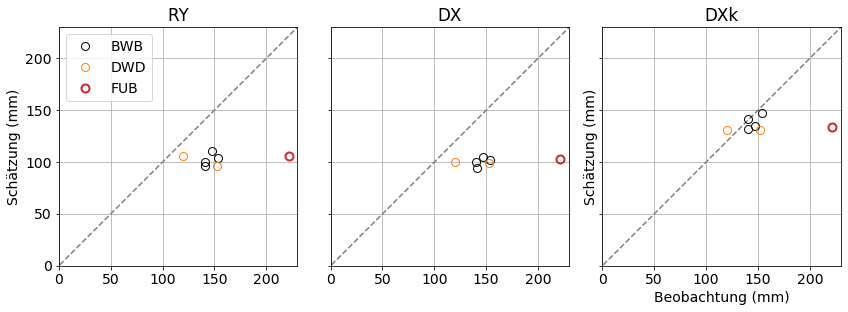

In [171]:
plt.rc('font', **{'size'   : 14})

# maxval = np.nanmax(np.array((rw_at_gauge.sum(axis=0).max(), rw_at_dwdgauge.sum(axis=0).max(),
#                              tmpdwd.sum(axis=0).max(), 
#                              tmpg.sum(axis=0).max(), dx_at_gauge.sum(axis=0).max(), 
#                              dx2_at_gauge.sum(axis=0).max(), dx2_at_dwdgauge.sum(axis=0).max(), 
#                              gosum_all_est.max())))
#maxval = np.ceil(maxval/10.) * 10.
maxval=230

fig, ax = plt.subplots(figsize=(12,8), nrows=1, ncols=3, sharex=True, sharey=True)
ax = ax.ravel()

#fig.suptitle(eventnames[eventix], fontsize=16)
plt.sca(ax[0])
ax[0].set_aspect("equal")
plt.plot([-10, maxval], [-10, maxval], color="grey", ms=0, ls="--")
plt.plot(np.array(bwb[bwbg_close].sum()), dfrybwb.sum(axis=0), "o", mfc="None", mec="black", ms=8, label="BWB")
plt.plot(np.array(dwd[dwdg_close].sum()), dfrydwd.sum(axis=0), "o", mfc="None", mec="tab:orange", ms=8, label="DWD")
plt.plot(np.array(fu[fug_close].sum()), dfryfu.sum(axis=0), "o", mfc="None", mec="tab:red", mew=2, ms=8, label="FUB")
plt.xlim(0,maxval)
plt.ylim(0,maxval)
#plt.xlabel("Beobachtung (mm)")
plt.ylabel("Schätzung (mm)")
plt.grid()
plt.title("RY")
plt.legend()
#rmse2plot(np.array(tmpg.sum())[gix], dx_at_gauge.sum(axis=0)[gix], maxval)

plt.sca(ax[1])
ax[1].set_aspect("equal")
plt.plot([-10, maxval], [-10, maxval], color="grey", ms=0, ls="--")
plt.plot(np.array(bwb[bwbg_close].sum()), dfdxbwb.sum(axis=0), "o", mfc="None", mec="black", ms=8, label="BWB")
plt.plot(np.array(dwd[dwdg_close].sum()), dfdxdwd.sum(axis=0), "o", mfc="None", mec="tab:orange", ms=8, label="DWD")
plt.plot(np.array(fu[fug_close].sum()), dfdxfu.sum(axis=0), "o", mfc="None", mec="tab:red", mew=2, ms=8, label="FUB")
plt.xlim(0,maxval)
plt.ylim(0,maxval)
#plt.xlabel("Beobachtung (mm)")
#plt.ylabel("Schätzung (mm)")
plt.grid()
plt.title("DX")
#rmse2plot(np.array(tmpg.sum())[gix], dx2_at_gauge.sum(axis=0)[gix], maxval)

plt.sca(ax[2])
ax[2].set_aspect("equal")
plt.plot([-10, maxval], [-10, maxval], color="grey", ms=0, ls="--")
plt.plot(np.array(bwb[bwbg_close].sum()), dfdx2bwb.sum(axis=0), "o", mfc="None", mec="black", ms=8, label="BWB")
plt.plot(np.array(dwd[dwdg_close].sum()), dfdx2dwd.sum(axis=0), "o", mfc="None", mec="tab:orange", ms=8, label="DWD")
plt.plot(np.array(fu[fug_close].sum()), dfdx2fu.sum(axis=0), "o", mfc="None", mec="tab:red", mew=2, ms=8, label="FUB")
plt.xlim(0,maxval)
plt.ylim(0,maxval)
plt.xlabel("Beobachtung (mm)")
plt.ylabel("Schätzung (mm)")
plt.grid()
plt.title("DXk")
#rmse2plot(np.array(tmpg.sum())[gix], rw_at_gauge.sum(axis=0)[gix], maxval)

plt.tight_layout()

plt.savefig("docs/report/scatter.png", dpi=300, bbox_inches="tight")

No handles with labels found to put in legend.


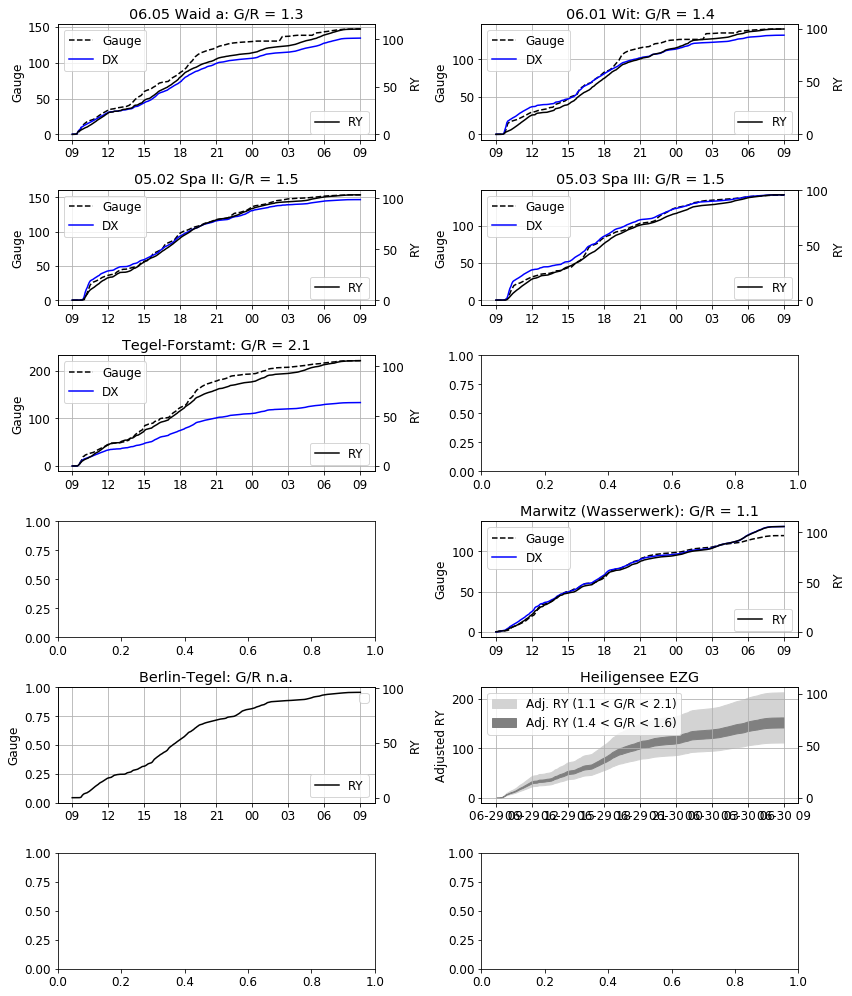

In [172]:
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(12,14))
ax = ax.ravel()

for i, id in enumerate(bwbg_close):
    plt.sca(ax[i])
    plt.plot(bwb[tstart:tend].index, bwb.loc[tstart:tend,id].cumsum(), ls="dashed", color="black", label="Gauge")
    plt.plot(dfdx2bwb.index, dfdx2bwb[id].cumsum(), color="blue", label="DX")
    plt.grid()
    plt.legend()
    plt.ylabel("Gauge")
    axt = ax[i].twinx()
    plt.sca(axt)
    plt.plot(dfrybwb.index, dfrybwb[id].cumsum(), color="black", label="RY")
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    fact = bwb.loc[tstart:tend, id].sum() / dfrybwb.loc[tstart:tend, id].sum()
    plt.title("%s: G/R = %.1f" % (id, fact))
    plt.legend(loc="lower right")
    plt.ylabel("RY")

for i, id in enumerate(fug_close):
    plt.sca(ax[i+4])
    plt.plot(fu[tstart:tend].index, fu.loc[tstart:tend,id].cumsum(), ls="dashed", color="black", label="Gauge")
    plt.plot(dfdx2fu.index, dfdx2fu[id].cumsum(), color="blue", label="DX")
    plt.grid()
    plt.legend()
    plt.ylabel("Gauge")
    axt = ax[i+4].twinx()
    plt.sca(axt)
    plt.plot(dfryfu.index, dfryfu[id].cumsum(), color="black", label="RY")
    ax[i+4].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    fact = fu.loc[tstart:tend, id].sum() / dfryfu.loc[tstart:tend, id].sum()
    plt.title("%s: G/R = %.1f" % (id, fact))
    plt.legend(loc="lower right")
    plt.ylabel("RY")

for i, id in enumerate(dwdg_close):
    plt.sca(ax[i+7])
    if not id==430:
        plt.plot(dwd[tstart:tend].index, dwd.loc[tstart:tend,id].cumsum(), ls="dashed", color="black", label="Gauge")
        plt.plot(dfdx2dwd.index, dfdx2dwd[id].cumsum(), color="blue", label="DX")
    plt.grid()
    plt.legend()
    plt.ylabel("Gauge")
    axt = ax[i+7].twinx()
    plt.sca(axt)
    plt.plot(dfrydwd.index, dfrydwd[id].cumsum(), color="black", label="RY")
    ax[i+7].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    if not id==430:
        fact = dwd.loc[tstart:tend, id].sum() / dfrydwd.loc[tstart:tend, id].sum()
        plt.title("%s: G/R = %.1f" % (dwdg_all.loc[id]["name"], fact))
    else:
        plt.title("%s: G/R n.a." % dwdg_all.loc[id]["name"])
    plt.legend(loc="lower right")
    plt.ylabel("RY")

plt.sca(ax[i+8])
plt.fill_between(dfryhlg[tstart:tend].index, 1.1*dfryhlg.loc[tstart:tend,0].cumsum(), 2.1*dfryhlg.loc[tstart:tend,0].cumsum(),
                color="lightgrey", label="Adj. RY (1.1 < G/R < 2.1)")
plt.fill_between(dfryhlg[tstart:tend].index, 1.4*dfryhlg.loc[tstart:tend,0].cumsum(), 1.6*dfryhlg.loc[tstart:tend,0].cumsum(),
                color="grey", label="Adj. RY (1.4 < G/R < 1.6)")

plt.grid()
plt.legend(loc="upper left")
plt.ylabel("Adjusted RY")
axt = ax[i+8].twinx()
plt.sca(axt)
plt.plot(dfryhlg[tstart:tend].index, dfryhlg.loc[tstart:tend,0].cumsum(), color="None", label="RY")
ax[i+7].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.title("Heiligensee EZG")
#plt.legend(loc="lower right")
plt.ylabel("")


plt.tight_layout()

plt.savefig("docs/events/gauges_vs_ry_cumsum_2017.png", dpi=300, bbox_inches="tight")

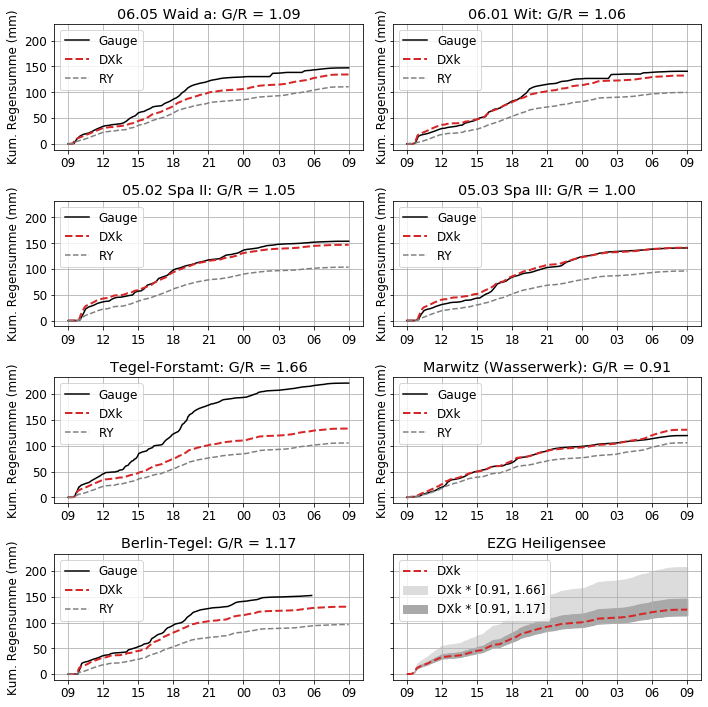

In [204]:
plt.rc('font', **{'size'   : 12})
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,10), sharey=True)
ax = ax.ravel()

coldxk = "tab:red"
lsdxk = "--"
colg = "black"
lsg = "-"
lwdxk = 2
colry = "grey"
lsry = "--"

for i, id in enumerate(bwbg_close):
    plt.sca(ax[i])
    fact = bwb.loc[tstart:tend, id].sum() / dfdx2bwb.loc[tstart:tend, id].sum()
    plt.plot(bwb[tstart:tend].index, bwb.loc[tstart:tend,id].cumsum(), ls=lsg, color=colg, label="Gauge")
    plt.plot(dfdx2bwb.index, dfdx2bwb[id].cumsum(), color=coldxk, ls=lsdxk, lw=lwdxk, label="DXk")
    plt.plot(dfrybwb.index, dfrybwb[id].cumsum(), color=colry, ls=lsry, label="RY")
    plt.grid()
    plt.legend(fontsize=12)
    plt.ylabel("Kum. Regensumme (mm)")    
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    plt.title("%s: G/R = %.2f" % (id, fact))

for i, id in enumerate(fug_close):
    j = len(bwbg_close) + i
    plt.sca(ax[j])
    fact = fu.loc[tstart:tend, id].sum() / dfdx2fu.loc[tstart:tend, id].sum()
    plt.plot(fu[tstart:tend].index, fu.loc[tstart:tend,id].cumsum(), ls=lsg, color=colg, label="Gauge")
    plt.plot(dfdx2fu.index, dfdx2fu[id].cumsum(), color=coldxk, ls=lsdxk, lw=lwdxk, label="DXk")
    plt.plot(dfryfu.index, dfryfu[id].cumsum(), color=colry, ls=lsry,  label="RY")
    #plt.plot(fu[tstart:tend].index, fu.loc[tstart:tend,id].cumsum()/1.5, ls="--", color=colg, label="Gauge/1.5")
    
    plt.grid()
    plt.legend(fontsize=12)
    plt.ylabel("Kum. Regensumme (mm)") 
    ax[j].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    plt.title("%s: G/R = %.2f" % (id, fact))

for i, id in enumerate(dwdg_close):
    j = len(bwbg_close) + len(fug_close) + i
    plt.sca(ax[j])
    fact = dwd.loc[tstart:tend, id].sum() / dfdx2dwd.loc[tstart:tend, id].sum()
    plt.plot(dwd[tstart:tend].index, dwd.loc[tstart:tend,id].cumsum(), ls=lsg, color=colg, label="Gauge")
    plt.plot(dfdx2dwd.index, dfdx2dwd[id].cumsum(), color=coldxk, ls=lsdxk,  lw=lwdxk, label="DXk")
    plt.plot(dfrydwd.index, dfrydwd[id].cumsum(), color=colry, ls=lsry,  label="RY")
    
    plt.grid()
    plt.legend(fontsize=12)
    plt.ylabel("Kum. Regensumme (mm)")
    ax[j].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    plt.title("%s: G/R = %.2f" % (dwdg_all.loc[id]["name"], fact))

plt.sca(ax[j+1])
plt.fill_between(dfryhlg[tstart:tend].index, 0.91*dfdx2hlg.loc[tstart:tend,0].cumsum(), 1.66*dfdx2hlg.loc[tstart:tend,0].cumsum(),
                color="gainsboro", label="DXk * [0.91, 1.66]")
plt.fill_between(dfryhlg[tstart:tend].index, 0.91*dfdx2hlg.loc[tstart:tend,0].cumsum(), 1.17*dfdx2hlg.loc[tstart:tend,0].cumsum(),
                color="darkgrey", label="DXk * [0.91, 1.17]")


plt.grid()

plt.plot(dfdx2hlg[tstart:tend].index, dfdx2hlg.loc[tstart:tend,0].cumsum(), color=coldxk, ls=lsdxk,  lw=lwdxk, label="DXk")
ax[j+1].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.title("EZG Heiligensee")
#plt.legend(loc="lower right")
plt.legend()


plt.tight_layout()

plt.savefig("docs/report/gauges_vs_ry_cumsum_2017.png", dpi=300, bbox_inches="tight")

In [236]:
# Export
dfdx2hlg["Datetime"] = dfdx2hlg.index
dfdx2hlg.columns = ["Niederschlag", "Datetime"]
dfdx2hlg = dfdx2hlg[["Datetime", "Niederschlag"]]
dfdx2hlg.to_csv("docs/report/Ndschlag_Heiligensee_2017-06-29_DXk.txt", float_format="%.4f", index=False)

Datetime        2017-06-29 09:00:002017-06-29 09:05:002017-06-...
Niederschlag                                              124.974
dtype: object

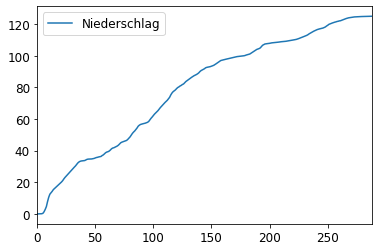

In [243]:
test = pd.read_csv("docs/report/Ndschlag_Heiligensee_2017-06-29_DXk.txt", sep=",", comment="#")
test.cumsum().plot()
test.sum()

In [220]:
1/1.5

0.6666666666666666

In [174]:
# #dfrw = dfrw.cumsum()
# # DX
# dfdx = pd.DataFrame(dx_at_gauge, index=dtimes)
# dfdx.columns = tmpg.columns
# #dfdx = dfdx.cumsum()
# # Attenutation corrected
# dfdx2 = pd.DataFrame(dx2_at_gauge, index=dtimes)
# dfdx2.columns = tmpg.columns
# #dfdx2= dfdx2.cumsum()
# # Gauge interpolation
# dfgauges = pd.DataFrame(go_all_5min, index=tmpg.index)
# dfgauges.columns = tmpg.columns
# #dfgauges = dfgauges.cumsum()

In [175]:
# tolerance = 0.99
# best = []
# for i, id in enumerate(tmpg.columns):
#     rmse_rad = h.rmse(tmpg.cumsum().loc[starts[eventix]:ends[eventix],id], 
#                       dfdx2.cumsum().loc[starts[eventix]:ends[eventix],id])
#     rmse_gauge = h.rmse(tmpg.cumsum().loc[starts[eventix]:ends[eventix],id], 
#                         dfgauges.cumsum().loc[starts[eventix]:ends[eventix],id])
#     if rmse_rad < tolerance*rmse_gauge:
#         best.append("rad")
#     elif rmse_gauge < tolerance*rmse_rad:
#         best.append("gauge")
#     else:
#         best.append("")
# #best[16] = "error"
# #best = np.array(best)
# #print("Radar superior or equivalent in %i cases" % len(np.where(best=="rad")[0]) )

In [176]:
# plt.rc('font', **{'size'   : 12})
# fig, ax = plt.subplots(nrows=10, ncols=5, figsize=(10,20), sharex=True)#, constrained_layout=True)
# #fig.suptitle(eventnames[eventix], fontsize=16)
# ax = ax.ravel()
# s = starts[eventix]
# e = ends[eventix]
# for i, id in enumerate(tmpg.columns):
#     plt.sca(ax[i])
#     #tmp = dfrw.cumsum().loc[s:e,id]
#     #plt.plot(tmp.index, tmp, label="RW (nur stündl.)", color="grey", lw=2)
#     tmp = tmpg.cumsum().loc[s:e,id]
#     plt.plot(tmp.index, tmp, label="R.schreiber", color="black", lw=2)
#     tmp = dfdx.cumsum().loc[s:e,id]
#     plt.plot(tmp.index, tmp, label="DX", color="darkgreen", lw=2)
#     tmp = dfdx2.cumsum().loc[s:e,id]
#     plt.plot(tmp.index, tmp, label="DX korr.", color="darkgreen", lw=2, ls="dashed")
#     tmp = dfgauges.cumsum().loc[s:e,id]
#     plt.plot(tmp.index, tmp, label="Interp.", color="grey", lw=2, ls="dotted")
#     plt.grid()
#     plt.xlabel("")
#     ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
#     plt.xticks(rotation=70)
#     if i==0:
#         plt.legend(fontsize=9)
#     if id in gauges.index[gauges[eventnames[eventix]]]:
#         ax[i].set_facecolor('mistyrose')
#         plt.title(id+" defekt!")
#     else:
#         plt.title(id)
#     #plt.ylabel("Kumulative Regenhöhe (mm)")
#     #if best[pi]=="rad":
#     #    plt.text(tmpg.index[1], 50, "Radar-QPE ist überlegen", color="darkgreen", fontsize=11)
#     #if best[pi]=="gauge":
#     #    plt.text(tmpg.index[1], 50, "Interp. ist überlegen", color="blue", fontsize=11)
#     #if best[pi]=="error":
#     #    plt.text(tmpg.index[1], 50, "Regenschreiber defekt!", color="red", fontsize=11)
#     #if pi==24:
#     #    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     #    plt.legend()
# plt.tight_layout()

# plt.savefig("docs/events/cumsumproducts_%s.png" % eventnames[eventix], dpi=300)

In [177]:
# plt.rc('font', **{'size'   : 12})
# fig, ax = plt.subplots(nrows=10, ncols=5, figsize=(10,20))#, constrained_layout=True)
# #fig.suptitle(eventnames[eventix], fontsize=16)
# ax = ax.ravel()
# s = starts[eventix]
# e = ends[eventix]
# for i, id in enumerate(tmpg.columns):
#     #if i>24:
#     #    break
#     #ax = plt.subplot(5,5,pi+1)
#     ax[i].set_aspect("equal")
#     plt.sca(ax[i])
#     tmp1 = tmpg.cumsum().loc[s:e,id]
#     tmp2 = dfdx.cumsum().loc[s:e,id]
#     tmp3 = dfdx2.cumsum().loc[s:e,id]
#     plt.plot(tmp1, tmp2, label="vs. DX", color="black", lw=2)
#     plt.plot(tmp1, tmp3, label="vs. DX2", color="black", lw=2, ls="dashed")
#     plt.plot([0,100], [0,100], color="grey", ls="dashed")
#     plt.grid()
#     plt.title(id)
#     plt.xlabel("")
#     maxval = np.nanmax(np.concatenate((tmp1, tmp2, tmp3)))
#     plt.xlim(0,maxval)
#     plt.ylim(0,maxval)
#     #ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
#     plt.xticks(rotation=20)
#     #plt.ylabel("Kumulative Regenhöhe (mm)")
#     #if best[pi]=="rad":
#     #    plt.text(tmpg.index[1], 50, "Radar-QPE ist überlegen", color="darkgreen", fontsize=11)
#     #if best[pi]=="gauge":
#     #    plt.text(tmpg.index[1], 50, "Interp. ist überlegen", color="blue", fontsize=11)
#     #if best[pi]=="error":
#     #    plt.text(tmpg.index[1], 50, "Regenschreiber defekt!", color="red", fontsize=11)
#     #if pi==24:
#     #    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     #    plt.legend()
# plt.tight_layout()

# plt.savefig("docs/events/cumscums_%s.png" % eventnames[eventix], dpi=300)

(0, 0.5)

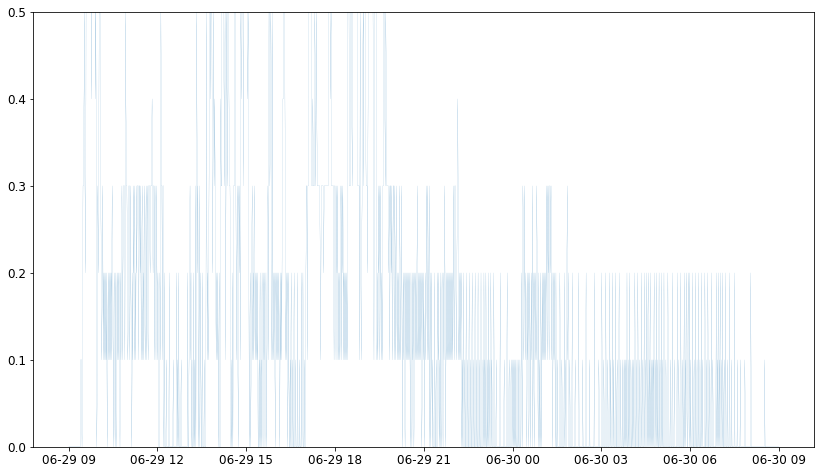

In [178]:
plt.figure(figsize=(14,8))
plt.plot(fu.index, fu["Tegel-Forstamt"], lw=0.1)
plt.ylim(0,0.5)